Anima biotech Home assignment

Your task is to perform clustering and extract valuable insights from a dataset of blood cell images. The dataset contains images containing various types of cells, including red blood cells, white blood cells, and platelets. Each image is accompanied by an XML file that provides information about the main category and bounding box, and there is also a main labels file containing subcategories specifically related to white blood cells (WBC) within each image.

To accomplish this, your goal is to leverage a pretrained neural network as your base model. While ResNet50 pretrained on ImageNet is a viable option, you are encouraged to consider alternative networks if you believe they may yield more advantageous results. If you opt for a different network or decide to utilize additional data to fine-tune the network, please ensure that your code and data are available for verification.

Your primary objectives include extracting embeddings from the blood cell images and applying clustering techniques to group these images, ultimately leading to the discovery of novel insights within the dataset. It's important to note that you are not permitted to use the provided labels for this task. However, you have the option to explore the utility of bounding box information, particularly if you choose to work at the individual cell level. Additionally, you may explore alternative approaches involving the incorporation of metadata related to the cellular environment.

Throughout your analysis, you are required to substantiate each decision you make with a clear rationale.

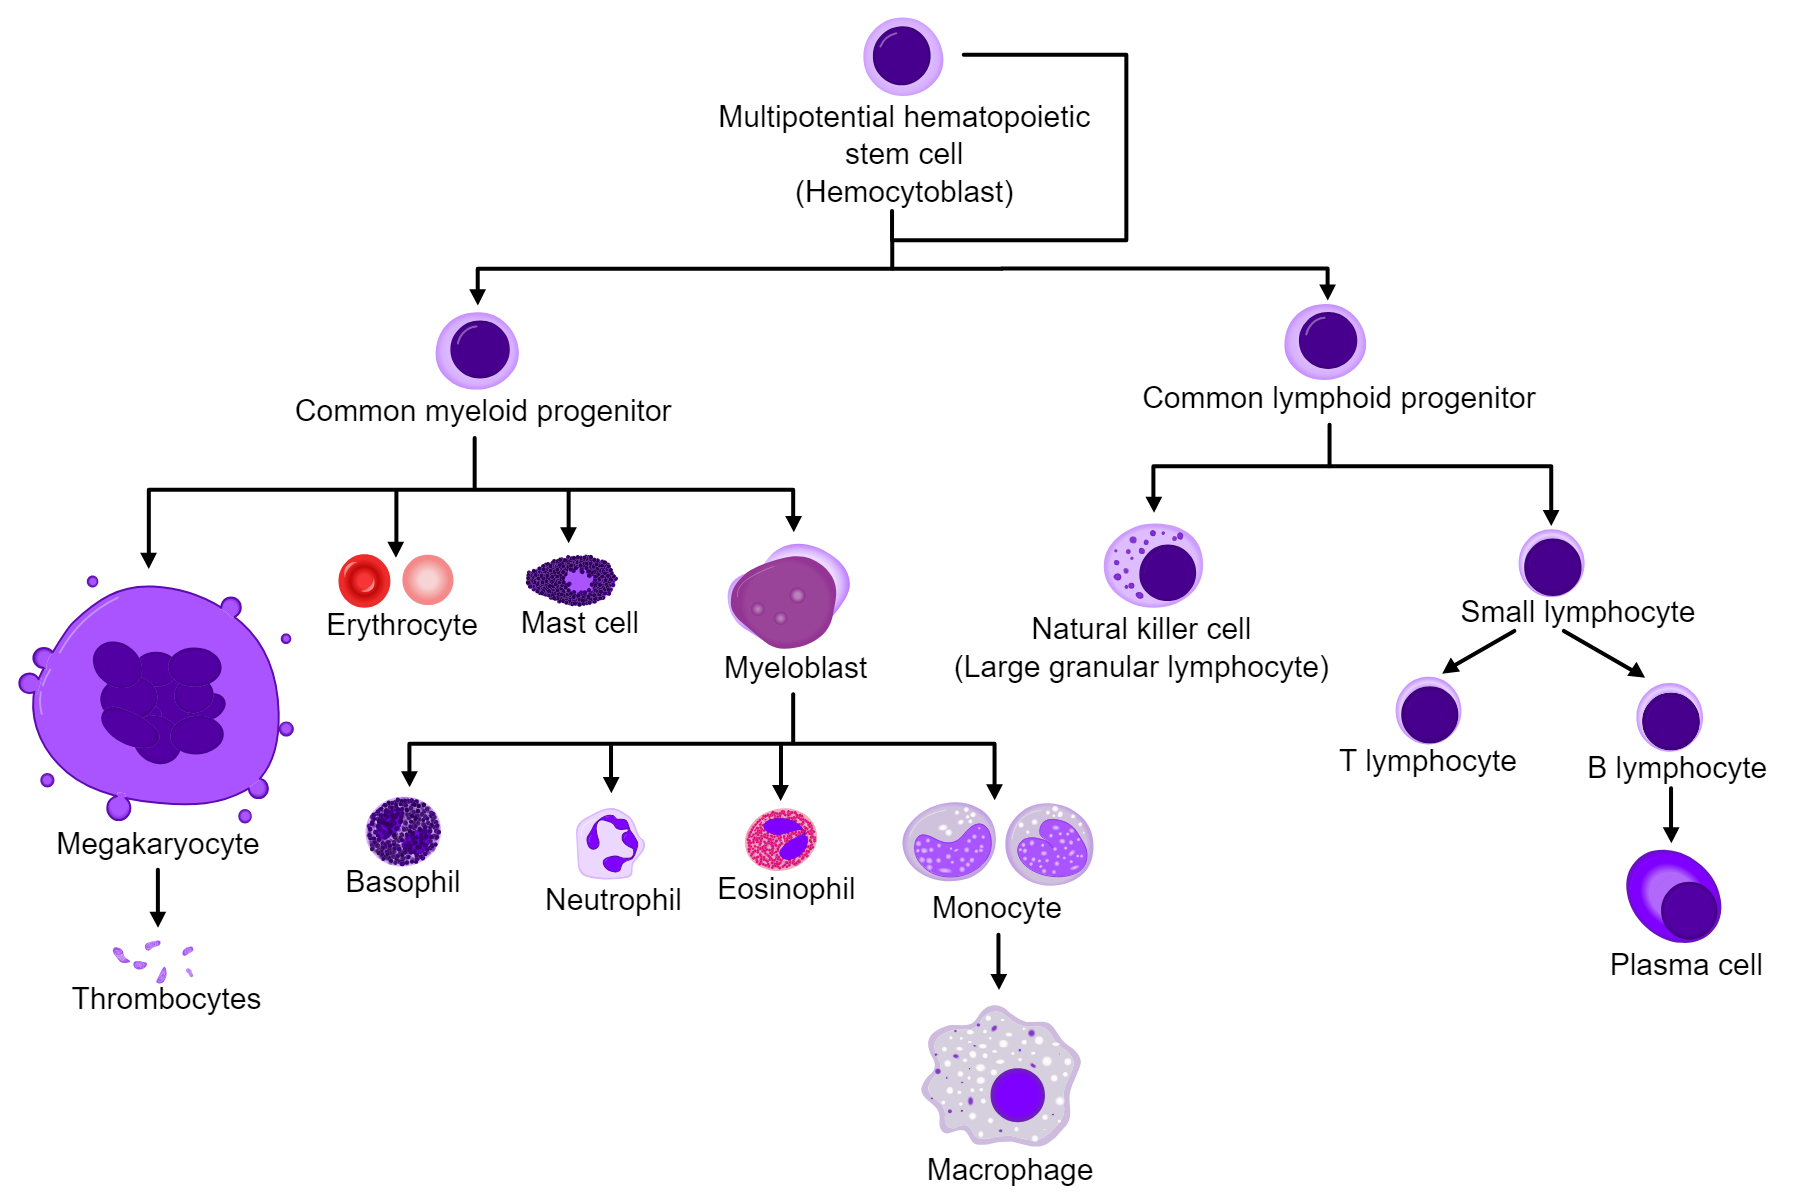

Clone git of blood cells dataset

In [1]:
!git clone https://github.com/Shenggan/BCCD_Dataset.git

Cloning into 'BCCD_Dataset'...
remote: Enumerating objects: 800, done.
remote: Total 800 (delta 0), reused 0 (delta 0), pack-reused 800
Receiving objects: 100% (800/800), 7.39 MiB | 13.22 MiB/s, done.
Resolving deltas: 100% (378/378), done.


Imports

In [2]:
!pip install umap-learn
import numpy as np
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
from keras.preprocessing import image
from google.colab.patches import cv2_imshow
import xml.etree.ElementTree as ET
import cv2
from tensorflow.keras.applications import ResNet50
from tensorflow import keras

Visualize image and labels from dataset

In [3]:
main_path = "./BCCD_Dataset/BCCD"
images_path = "{}/JPEGImages".format(main_path)
annotations_path = "{}/Annotations".format(main_path)
image_files = glob(images_path + "/*.jpg")

print(f"Number of samples: {len(image_files)}")


Number of samples: 364


Visualize raw image

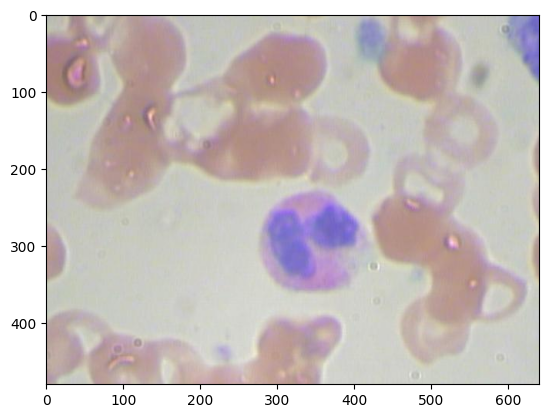

In [4]:
plt.imshow(image.img_to_array(image.load_img(image_files[0])).astype('uint8'))
plt.show()

Visualize image with annotations from XML file and labels of White blood cells

NEUTROPHIL, EOSINOPHIL


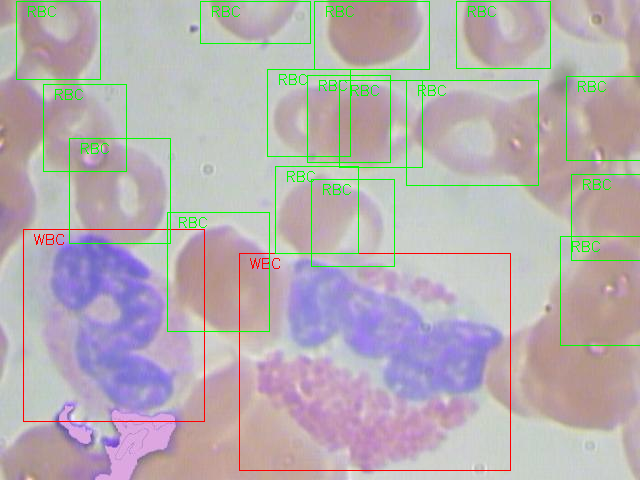

(18, 224, 224, 3)
NEUTROPHIL, EOSINOPHIL


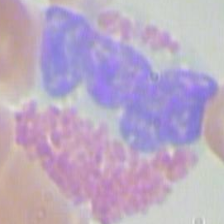

In [8]:
labels_csv = pd.read_csv("{}/labels.csv".format(main_path))

image_number = 10

print(labels_csv['Category'].values[image_number])

image_instance = "BloodImage_000{}".format(image_number)

temp_image = cv2.imread("{}/{}.jpg".format(images_path,image_instance))

def parse(image,annotations_path,image_instance,crop=False):
  single_cells = []
  RWC=[]
  tree = ET.parse("{}/{}.xml".format(annotations_path,image_instance))
  for elem in tree.iter():
    if 'object' in elem.tag or 'part' in elem.tag:
      for attr in list(elem):
        if 'name' in attr.tag:
          name = attr.text
        if 'bndbox' in attr.tag:
          for dim in list(attr):
            if 'xmin' in dim.tag:
              xmin = int(round(float(dim.text)))
            if 'ymin' in dim.tag:
              ymin = int(round(float(dim.text)))
            if 'xmax' in dim.tag:
              xmax = int(round(float(dim.text)))
            if 'ymax' in dim.tag:
              ymax = int(round(float(dim.text)))
          if not crop:
            if name[0] == "R":
              cv2.rectangle(image, (xmin, ymin),
                    (xmax, ymax), (0, 255, 0), 1)
              cv2.putText(image, name, (xmin + 10, ymin + 15),
                  cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (0, 255, 0), 1)
            if name[0] == "W":
              cv2.rectangle(image, (xmin, ymin),
                    (xmax, ymax), (0, 0, 255), 1)
              cv2.putText(image, name, (xmin + 10, ymin + 15),
                  cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (0, 0, 255), 1)
            if name[0] == "P":
              cv2.rectangle(image, (xmin, ymin),
                    (xmax, ymax), (255, 0, 0), 1)
              cv2.putText(image, name, (xmin + 10, ymin + 15),
                  cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (255, 0, 0), 1)
          else:
            try:
              single = np.copy(image[ymin:ymax,xmin:xmax])
              single_cells.append(cv2.resize(single,(224,224)))
              if name[0] == "W":
                image_number = int(image_instance.split('_')[1])
                name = labels_csv['Category'].values[image_number]
              RWC.append(name)
            except Exception as e:
              continue
  if not crop:
    return image, RWC
  else:
    return np.array(single_cells),RWC

image,_ = parse(np.copy(temp_image),annotations_path,image_instance)
cv2_imshow(image)
cv2.waitKey()

single_cells, RWC = parse(temp_image,annotations_path,image_instance,True)
print(single_cells.shape)
print(RWC[1])
cv2_imshow(single_cells[1])

Preprocess data

Download pretrained network

94765736/94765736 [==============================] - 0s 0us/step


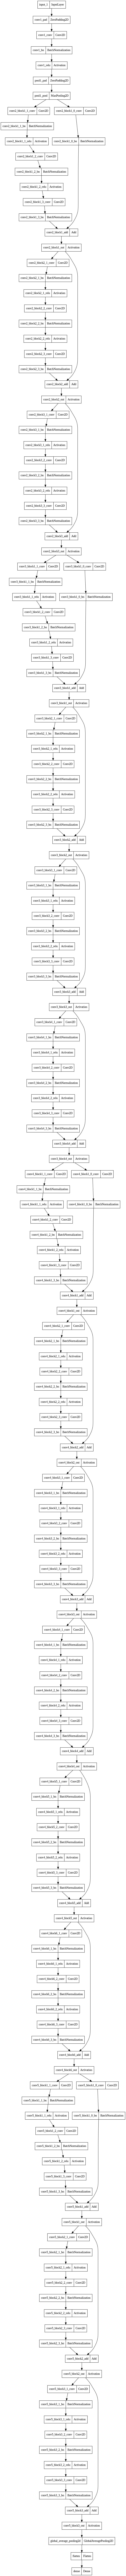

In [6]:
resnet =  ResNet50(input_shape = (224,224,3) ,include_top=False,weights='imagenet')

z = keras.layers.GlobalAveragePooling2D()(resnet.output)
z = keras.layers.Flatten()(z)
out = keras.layers.Dense(20,"softmax")(z)

for layer in resnet.layers:
    layer.trainable = False

resnet_model = keras.models.Model(inputs=resnet.input , outputs = [z,out])

keras.utils.plot_model(resnet_model, "ResNet.png")

Finetune model

Extract embeddings

In [9]:

instances = []
labels = []
# numbers = []
images = None
imagenet_embeddings = None
c=0
for image_file in image_files:
  # print(image_file)
  image = cv2.imread(image_file)
  image_instance = image_file.split('/')[-1].split('.jpg')[0]
  image_number = int(image_instance.split('_')[1])
  try:
    # label = cell_labels_dict[labels_csv['Category'].values[image_number]]
    # print(image_instance)
    single_cells,RWC = parse(np.copy(image),annotations_path,image_instance,True)
    # print(single_cells.shape)
    z = resnet_model(single_cells)[0]
    if images is None:
      labels=RWC
      images = single_cells
      imagenet_embeddings = z
    else:
      labels = [*labels,*RWC]
      images = np.concatenate([images,single_cells])
      imagenet_embeddings = np.concatenate([imagenet_embeddings,z])

    # labels.append(label)
    # numbers.append(image_number)
  except Exception as e:
    continue
  # print(image_number)
  # print(label)

imagenet_embeddings = np.array(imagenet_embeddings)
labels = np.array(labels)
print(imagenet_embeddings.shape)
print(len(labels))

(4886, 2048)
4886


Extract insights

In [18]:

from sklearn.decomposition import PCA
import umap as um
import plotly.express as px

# pca = PCA(n_components=3)
# comps = pca.fit_transform(imagenet_embeddings)
# print(pca.explained_variance_ratio_)

print(imagenet_embeddings.shape)
comps = um.UMAP(n_components=5).fit_transform(imagenet_embeddings)

px.scatter(pd.DataFrame({'comp0':comps[:,0],'comp1':comps[:,1],'comp2':comps[:,2],'comp3':comps[:,3],'comp4':comps[:,4],'label':labels,'image':range(images.shape[0])}), x='comp0',y='comp1',color="label",hover_data=['label','image'])

(4886, 2048)


RBC Group A


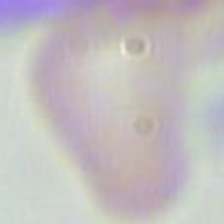

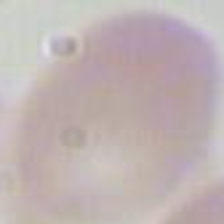

RBC Group B


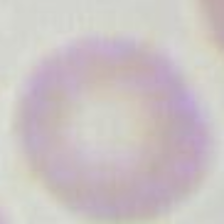

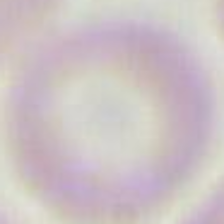

RBC Group C


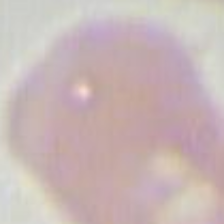

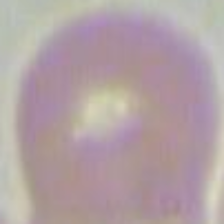

In [16]:
print("RBC Group A")
cv2_imshow(images[2425])
cv2_imshow(images[1548])
print("RBC Group B")
cv2_imshow(images[2295])
cv2_imshow(images[1440])
print("RBC Group C")
cv2_imshow(images[1282])
cv2_imshow(images[3915])

Finetune network according to labels

In [19]:
from sklearn.preprocessing import LabelEncoder
resnet_model.compile(optimizer ='adam', loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])
int_labels = LabelEncoder().fit_transform(labels)
resnet_model.fit(images,int_labels,batch_size=32,epochs=5,validation_split=0.5)

Epoch 1/5
77/77 [==============================] - 22s 217ms/step - loss: 13.8943 - flatten_loss: 13.4858 - dense_loss: 0.4085 - flatten_accuracy: 0.0000e+00 - dense_accuracy: 0.9144 - val_loss: 13.8678 - val_flatten_loss: 13.6971 - val_dense_loss: 0.1707 - val_flatten_accuracy: 0.0000e+00 - val_dense_accuracy: 0.9652
Epoch 2/5
77/77 [==============================] - 18s 230ms/step - loss: 13.6068 - flatten_loss: 13.4858 - dense_loss: 0.1210 - flatten_accuracy: 0.0000e+00 - dense_accuracy: 0.9722 - val_loss: 13.8304 - val_flatten_loss: 13.6971 - val_dense_loss: 0.1333 - val_flatten_accuracy: 0.0000e+00 - val_dense_accuracy: 0.9722
Epoch 3/5
77/77 [==============================] - 15s 198ms/step - loss: 13.5677 - flatten_loss: 13.4858 - dense_loss: 0.0819 - flatten_accuracy: 0.0000e+00 - dense_accuracy: 0.9824 - val_loss: 13.8274 - val_flatten_loss: 13.6971 - val_dense_loss: 0.1303 - val_flatten_accuracy: 0.0000e+00 - val_dense_accuracy: 0.9742
Epoch 4/5
77/77 [=======================

In [20]:
embeddings = None
for image_file in image_files:
  # print(image_file)
  image = cv2.imread(image_file)
  image_instance = image_file.split('/')[-1].split('.jpg')[0]
  image_number = int(image_instance.split('_')[1])
  try:
    single_cells,RWC = parse(np.copy(image),annotations_path,image_instance,True)
    z = resnet_model(single_cells)[0]
    if embeddings is None:
      embeddings = z
    else:
      embeddings = np.concatenate([embeddings,z])

  except Exception as e:
    continue


embeddings = np.array(embeddings)


In [22]:
# pca = PCA(n_components=3)
# comps = pca.fit_transform(embeddings)
# print(pca.explained_variance_ratio_)

print(embeddings.shape)
comps = um.UMAP(n_components=3).fit_transform(embeddings)

px.scatter(pd.DataFrame({'comp0':comps[:,0],'comp1':comps[:,1],'comp2':comps[:,2],'label':labels,'image':range(images.shape[0])}), x='comp0',y='comp2',color="label",hover_data=['label','image'])

(4886, 2048)
